# Assignment 5: TRDM Exploration
## Quantified Cognition
### Psychology 5332


# Name: *Your Name Here*
# User ID: *Your ID Here*

# Objectives

Upon completion of this assignment, the student will demonstrate the ability to:

1. Modify a model to test a hypothesis
2. Fit the model to data
3. Plot parameter posteriors
4. Evaluate model fit results


# Assignment

- The goal of this assignment is to test two alternative hypotheses about the underlying decision-making processes change with a speed--accuracy trade-off. 

- You will perform this assignment by writing code in *this notebook* (***after making a copy and renaming it to have your userid in the title --- e.g., A05_TRDM_Exploration_mst3k***).

- In addition to this notebook, you will need to download the data from the same directory on GitHub. The file is decision_data.csv.

- ***When you are done, save this notebook as HTML (`File -> Download as -> HTML`) and upload it to the matching assignment on UVACollab.***

## HINTS

- Be sure to comment your code
- I have provided cells with general instructions for what they should contain.
  

## Model variants

We will be focusing on the timed racing diffusion model (TRDM). In class we demonstrated that the model did a fairly good job of capturing the speed--accuracy trade-off data by changing the drift rate of the timing process (see the `vt_A` and `vt_S` parameters). In the speeded condition the timer accumulated much faster such that decisions were made based on the timer more often (i.e., the participant felt urgency to make a response and guessed based on the evidence they had accumulated up until that point.)

In this model, there is a parameter (`rho`) that determines what information is used to guide the decisions when the timer crosses its threshold before either of the choices. If `rho=0`, then the model guesses randomly between the two cases. If `rho=1`, then the model makes its decision based on the amount of evidence accumulated for each choice up until that point. Any value in between determines the relative trade-off between those two approaches for timer-based decisions.

For the previous analysis, we let `rho` be a free parameter, allowed to take on any value between zero and one. For this assignment, we will test two model variants to see how they perform relative to this first model:

1) A model with `rho` fixed at zero, so timer-based decisions are random guesses between the choices.

2) A model with `rho` fixed at one, so the timer-based decisions use the information accumulated up until that point to guide the decision.

***I have pasted the code from class for the base model below. Your task will be to modifiy the code to change the rho parameter to be fixed (see the commented code, which is the only change you need to make) and then rerun the models and interpret the results.***


In [1]:
# Load in necessary modules
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import arviz as az

from RunDEMC.density import kdensity
from RunDEMC import Model, Param, dists
from RunDEMC import DE, calc_bpic, joint_plot
from RunDEMC.io import arviz_dict

from waldrace import trdm_like, trdm_gen


In [2]:
# load in the data
dat = pd.read_csv('decision_data.csv', index_col=0)
dat = dat[dat.cond != 'Neutral']
dat['rt_acc'] = dat['rt']
dat.loc[dat.correct==0,'rt_acc'] = -dat['rt']
dat.head()

,correct,rt,cond,log_rt,rt_acc
3,1,0.4784,Accuracy,-0.737308,0.4784
4,1,0.4300,Accuracy,-0.843970,0.4300
5,1,0.4486,Accuracy,-0.801624,0.4486
6,1,0.3991,Speed,-0.918543,0.3991
8,1,0.4393,Accuracy,-0.822573,0.4393


In [3]:
# grab the beh data of interest
choices_A = np.array(dat[(dat['cond']=='Accuracy')]['correct']+1)
rts_A = np.array(dat[(dat['cond']=='Accuracy')]['rt'])
choices_S = np.array(dat[(dat['cond']=='Speed')]['correct']+1)
rts_S = np.array(dat[(dat['cond']=='Speed')]['rt'])
min_rt = dat.rt.min()

In [4]:
# set up the sim
cond='Accuracy'

# normed histogram
def dhist(dat, nvals, alpha=.3, color='b'):
    p,b = np.histogram(dat, bins='auto', density=True)
    w = b[1]-b[0]
    p *= float(len(dat))/nvals
    return plt.bar(b[1:]-w, p, width=w, alpha=.3, color=color)

# normed pdf
xvals = np.linspace(0.0,2.0,1000)

# put it all together
def run_trdm(cond, v_1=0.25, v_2=0.75, v_t=0.1, theta=0.0,
             sig=1.0, sig_t=0.5, rho=0.0):

    ndat = (dat['cond']==cond).sum()
    # plot the hist of the data, followed by the model PDF line
    dhist(np.array(dat[(dat['cond']==cond)&(dat['correct']==1)]['rt']), ndat, color='b')
    likes = trdm_like(np.ones(len(xvals))*2, xvals, 
                      v=[v_1, v_2, v_t], alpha=1.0, theta=theta,
                      sig=[sig, sig, sig_t], rho=rho)
    plt.plot(xvals, likes, color='b', lw=2.)
    
    dhist(np.array(dat[(dat['cond']==cond)&(dat['correct']==0)]['rt']), ndat, color='r')
    likes = trdm_like(np.ones(len(xvals))*1, xvals, 
                      v=[v_1, v_2, v_t], alpha=1.0, theta=theta,
                      sig=[sig, sig, sig_t], rho=rho)
    plt.plot(xvals, likes, color='r', lw=2.)
    #ylim(0,5.0)
    plt.xlim(0,2.0)

## DUPLICATE THE FOLLOWING CELLS AND MAKE NECESSARY CHANGES TO TEST NEW HYPOTHESES

In [5]:
# Test change in timer drift

# set up the params
params = [Param(name='v1', prior=dists.trunc_normal(2.0, 2.0, 0., 5.0)),
          Param(name='v2', prior=dists.trunc_normal(2.0, 2.0, 0., 5.0)),
          Param(name='vt_A', prior=dists.trunc_normal(2.0, 2.0, 0., 5.0)),
          Param(name='vt_S', prior=dists.trunc_normal(2.0, 2.0, 0., 5.0)),
          Param(name='sig', prior=dists.halfcauchy(5.0)),
          Param(name='sig_t', prior=dists.halfcauchy(5.0)),
          Param(name='rho', prior=dists.normal(0, 1.4),
                transform=dists.invlogit),
          #Param(name='rho', prior=0.0),
          Param(name='t0', prior=dists.normal(0, 1.4), 
                transform=lambda x: dists.invlogit(x)*min_rt)]
param_names = [p.name for p in params]

# define the likelihood function
def like_fun(pop, *args):
    likes = np.zeros(len(pop))
    for i,p in enumerate(pop):
        # first Accuracy
        likes_A = trdm_like(choices_A, rts_A, 
                            v=[p['v1'], p['v2'], p['vt_A']], 
                            alpha=1.0, 
                            theta=p['t0'],
                            sig=[p['sig'], p['sig'], p['sig_t']], 
                            rho=p['rho'])
        likes[i] += np.log(likes_A).sum()
        if likes[i] == -np.inf:
            continue
            
        # then Speed
        likes_S = trdm_like(choices_S, rts_S, 
                            v=[p['v1'], p['v2'], p['vt_S']], 
                            alpha=1.0, 
                            theta=p['t0'],
                            sig=[p['sig'], p['sig'], p['sig_t']], 
                            rho=p['rho'])
        likes[i] += np.log(likes_S).sum()

    return likes

       
# make the model
m = Model('trdm', params=params,
          like_fun=like_fun,
          pop_parallel=True,
          verbose=True)


# do some burnin
times = m.sample(100, burnin=True)

# sample from the posterior
times = m.sample(500, burnin=False)


print("Best fitting params:")
burnin=200
best_ind = m.weights[burnin:].argmax()
print("Weight:", m.weights[burnin:].ravel()[best_ind])
print("BPIC:", calc_bpic(m.weights[burnin:])['bpic'])

indiv = [m.particles[burnin:,:,i].ravel()[best_ind] 
         for i in range(m.particles.shape[-1])]
pp = {}
for p,v in zip(m.param_names,indiv):
    pp[p] = v
    print('"%s": %f,'%(p,v))
    

Initializing: 80(80) 8(8) Iterations (100):


Iterations (500):


Best fitting params:
Weight: 235.47127498698202
BPIC: -450.543626221524
"v1": 0.325377,
"v2": 1.989510,
"vt_A": 0.779773,
"vt_S": 4.514289,
"sig": 0.634516,
"sig_t": 0.785612,
"rho": 0.472381,
"t0": 0.155141,


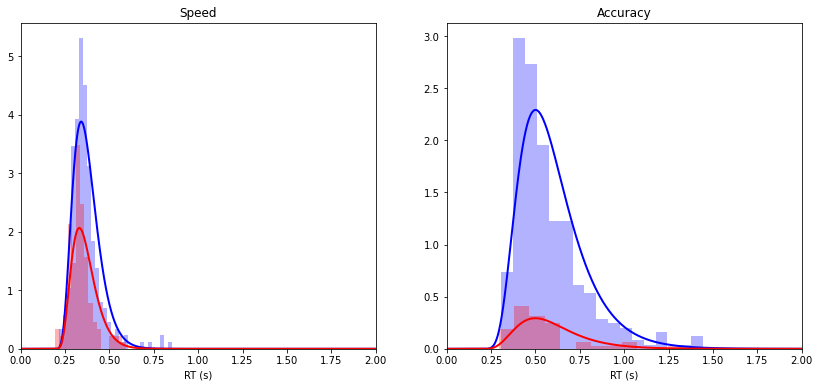

In [6]:
# set up new figure
plt.figure(figsize=(14,6))

# try different params!
plt.subplot(1,2,1)
cond='Speed'
run_trdm(cond, v_1=pp['v1'], v_2=pp['v2'], v_t=pp['vt_S'],
         theta=pp['t0'], sig=pp['sig'], sig_t=pp['sig_t'], rho=pp['rho'])
plt.xlabel('RT (s)')
plt.xlim(0,2.0)
plt.title(cond)

plt.subplot(1,2,2)
cond='Accuracy'
run_trdm(cond, v_1=pp['v1'], v_2=pp['v2'], v_t=pp['vt_A'],
         theta=pp['t0'], sig=pp['sig'], sig_t=pp['sig_t'], rho=pp['rho'])
plt.xlabel('RT (s)')
plt.xlim(0,2.0)
plt.title(cond);

## Evaluation

***How did setting rho to a fixed value affect the performance, especially in the speeded condition where the timer was getting used more?***

***Of the three models (free rho, rho=0, rho=1), which provided the best fit based on BPIC?***

### Write your short answer here:
